# Time Series Forecasting

This notebook shows a demonstration of the *SARIMA* model to forecast revenue.

#### Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### Helper Functions

In [2]:
def dickeyfuller_test(X):
    '''Helper Function to check if stationary'''
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [3]:
# Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
    model = ARIMA(Actual, order=(P, D, Q))
    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast(steps=1)[0]
    conf = model_fit.forecast(steps=1)[2]
    if k==332:
        print(model_fit.summary())
        plt.show()
    return prediction,conf


The *StartARIMAForecasting* function creates an *ARIMA model*. The *Fits()* function fits the *ARIMA(p,d,q)* model by exact maximum likelihood via *Kalman filter*. *Forecast()* returns an estimated value based on the fitted *ARIMA* model.

## Data Exploration

In [4]:
# Read in data
data = pd.read_csv('../Data/sarima-data.csv', header=0)
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.head(10)

Date  Data-Point-2
0 2011-01-01      60724.10
1 2011-02-01     116297.67
2 2011-03-01     138717.04
3 2011-04-01     110321.72
4 2011-05-01     131121.48
5 2011-06-01      68549.86
6 2011-07-01      26592.53
7 2011-08-01      29821.77
8 2011-09-01      26325.67
9 2011-10-01      17500.15

The dataset provided includes the total retail sales per month in £s.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 2 columns):
Date            96 non-null datetime64[ns]
Data-Point-2    96 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 KB


In [6]:
df = data[["Date","Data-Point-2"]].copy()

# Check if there are rows with missing values on the data set
df.isnull().any().any()

True

### Exclude Rows with Missing Values

In [7]:
# Drop all rows that have any NaN values
df = df.dropna()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 95
Data columns (total 2 columns):
Date            96 non-null datetime64[ns]
Data-Point-2    96 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 KB


### Plot Time Series

Plot the time series of sales.

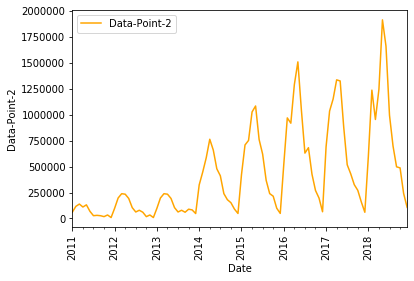

In [9]:
ax = plt.gca()
df.plot(kind='line',x="Date",y="Data-Point-2", color='orange', ax=ax)
plt.ylabel("Data-Point-2")
plt.xticks(rotation='vertical')

plt.show()

### Seasonality

We will decompose the data to view the trend and seasonal pattern.  A seasonal element is clearly seen.

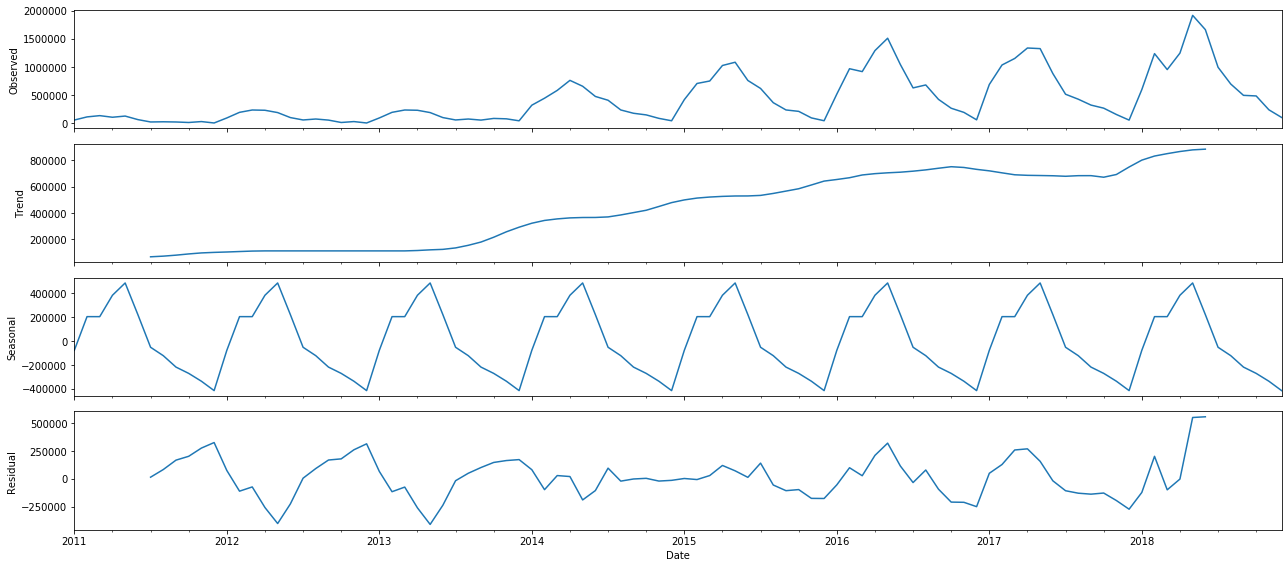

In [10]:
y = df.set_index(['Date'])
y.head(5)

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## Rolling Forecast *Seasonal Auto Regressive Moving Average (SARIMA)* Model 

### Choose Parameters
There is an automatic *ARIMA* package in *Python* that will find the best model for your data. In the time series, there is clearly a *seasonal* element whereby the number of sales increases and decreases on a cyclic nature throughout the year so we will perform the auto *ARIMA* function with a yearly *seasonal* component (m=12 because we have monthly data).  

For *SARIMA*, our data set has to be *stationary* (have a constant mean and variance). If not, the data set is *differenced*. The auto *ARIMA* determines this via the *Augmented Dicky Fuller (ADF) test* and *differences* the data set if necessary.

In [11]:
import pmdarima as pm


model = pm.auto_arima(df["Data-Point-2"], start_p=1, start_q=1, 
                      test='adf',       # use adf test to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   
                      start_P=0, 
                      D=1,              # D=1 if it has a well defined seasonal pattern which it does here
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=2220.287, BIC=2232.441, Fit time=0.151 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=2274.173, BIC=2279.034, Fit time=0.009 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=2221.932, BIC=2231.655, Fit time=0.118 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=2230.082, BIC=2239.805, Fit time=0.117 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=2221.329, BIC=2235.914, Fit time=0.277 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=2223.183, BIC=2232.906, Fit time=0.050 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=2217.593, BIC=2232.178, Fit time=0.423 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=2228.872, BIC=2241.026, Fit time=0.415 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=2215.909, BIC=2232.925, Fit time=0.825 seconds
Fit ARIMA: order=(2, 0, 0) s

The model shows that the yearly cycle is **not** *statistically significant* (p=0.501) which is more than 0.05.

In [23]:
model = pm.auto_arima(df["Data-Point-2"], start_p=1, start_q=1, 
                      test='adf',       # use adf test to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=24,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,
                      start_P=0, 
                      D=1,              # D=1 if it has a well defined seasonal pattern which it does here
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 24); AIC=1981.516, BIC=1986.070, Fit time=0.022 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 24); AIC=1927.425, BIC=1936.532, Fit time=0.384 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 24); AIC=1928.238, BIC=1935.068, Fit time=0.038 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 24); AIC=1929.146, BIC=1940.530, Fit time=1.268 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 24); AIC=1981.883, BIC=1988.713, Fit time=0.276 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 1, 0, 24); AIC=1926.785, BIC=1

The results of the auto *ARIMA* function shows that the *SARIMA* model with the lowest *AIC* and *BIC* is *SARIMA*(2,0,1) with *seasonal* order (0,1,0,24). The value of 24 indicates a two year cycle. Here it shows that the *seasonal* element was *differenced* to enable *stationarity*.

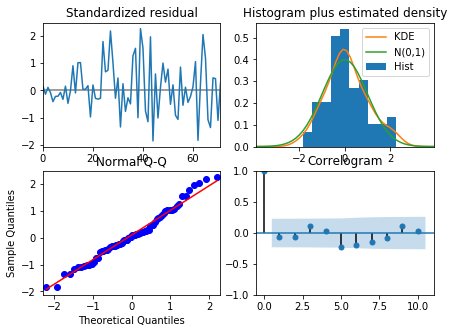

                                 Statespace Model Results                                 
Dep. Variable:                       Data-Point-2   No. Observations:                   96
Model:             SARIMAX(2, 0, 1)x(0, 1, 0, 24)   Log Likelihood                -954.197
Date:                            Fri, 06 Dec 2019   AIC                           1918.393
Time:                                    10:30:27   BIC                           1929.777
Sample:                                         0   HQIC                          1922.925
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.828e+04   6.31e+04      1.083      0.279   -5.53e+04    1.92e+05
ar.L1          0.2880      0.149   

In [13]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

# SARIMA Model
model = SARIMAX(df["Data-Point-2"], order=(2,0,1), seasonal_order=(0,1,0,24),trend='c',enforce_invertibility=False)
model_fit = model.fit()
print(model_fit.summary())

## Split to Train and Test Set

To train the model, 75% of the data with the remaining 25% to test the accuracy.

In [19]:
NumberOfElements = len(df["Data-Point-2"])
TrainingSize = int(NumberOfElements * 0.75)
train = df["Data-Point-2"][0:TrainingSize]
test = df["Data-Point-2"][TrainingSize:NumberOfElements]


## Build a Model

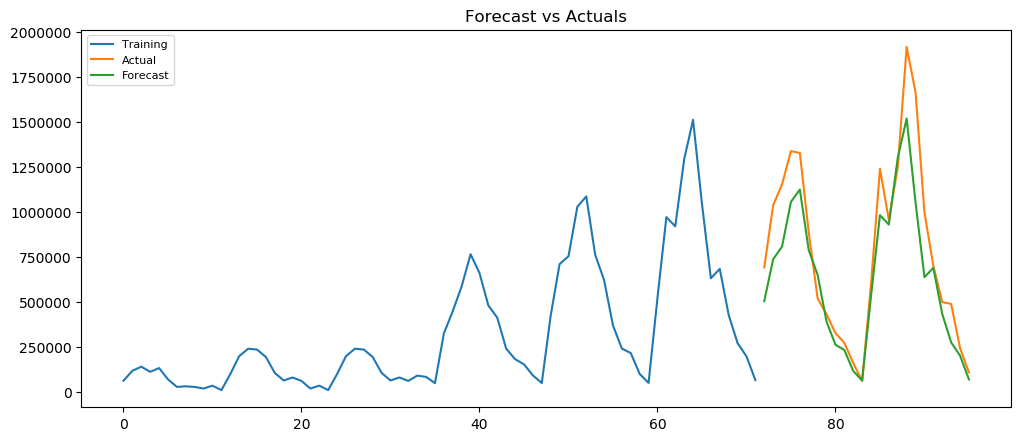

In [20]:
# Build Model
model = SARIMAX(train, order=(2, 0, 1), 
                seasonal_order=(0,1,0,24),
                enforce_stationarity=False, 
                enforce_invertibility=False)  
fitted = model.fit()  

# Forecast 24 steps ahead
forecast_values=fitted.get_forecast(steps=24)

# Confidence intrevals for forecast
forecast_ci=forecast_values.conf_int()

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(forecast_values.predicted_mean, label='Forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Accuracy metrics

In [21]:
y_forecasted=forecast_values.predicted_mean
actual=df["Data-Point-2"]

In [22]:
# Define accuracy metrics

def forecast_accuracy(y_forecasted, actual):
    mape = (abs(y_forecasted - actual)/abs(actual)).mean()  # Mean Absolute Percentage Error
    me = (y_forecasted - actual).mean()                     # Mean Error
    mse=((y_forecasted-actual)**2).mean()                   # Mean Square Error
    mae = (abs(y_forecasted - actual)).mean()               # Mean Absolute Error
    mpe = ((y_forecasted - actual)/actual).mean()           # Mean Percentage Error
    rmse = (((y_forecasted - actual)**2)).mean()**.5        # Root Mean Square Error
    return({'mape':mape, 'me':me, 'mse':mse, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse}), 

forecast_accuracy(y_forecasted, actual)

({'mape': 0.1999494632436212,
  'me': -146139.2250533004,
  'mse': 49505351715.119865,
  'mae': 161622.51188084902,
  'mpe': -0.17183747341066283,
  'rmse': 222497.98137313485},)

The *MAPE* implies the model is about 80% accurate in predicting the next 24 months. Let us now forecast using our model for the next two years.

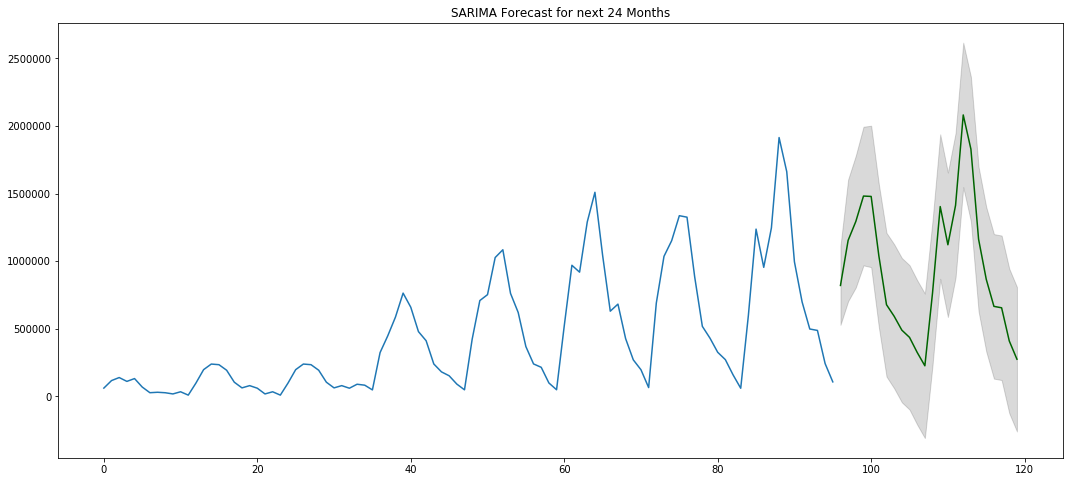

In [24]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df["Data-Point-2"]), len(df["Data-Point-2"])+n_periods)

# Make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df["Data-Point-2"])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast for next 24 Months")
plt.show()